In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import WeightedRandomSampler, DataLoader

In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("phatntse192617/celeba-spoof-mini")

# print("Path to dataset files:", path)

In [3]:
# import kagglehub
# import shutil
# import os

# # 1. Download to temporary cache
# cache_path = kagglehub.dataset_download("phatntse192617/celeba-spoof-mini")
# print("Downloaded to cache:", cache_path)

# # 2. Define your target local directory
# target_path = "../data/celeba-spoof-mini"

# # 3. Move the data
# if not os.path.exists("..data"):
#     os.makedirs("../data")

# if not os.path.exists(target_path):
#     # Move from cache to your local data folder
#     shutil.move(cache_path, target_path)
#     print(f"Data moved to: {target_path}")
# else:
#     print(f"Data already exists at: {target_path}")

In [4]:
import os

# Start from your current working directory
base_search_path = os.getcwd()

train_path = None
val_path = None

# Search recursively for the actual 'train' and 'val' folders
for root, dirs, files in os.walk(os.path.abspath(os.path.join(base_search_path, ".."))):
    if "train" in dirs and "val" in dirs:
        # Check if these folders actually contain 'live' or 'spoof'
        subdirs = os.listdir(os.path.join(root, "train"))
        if "live" in subdirs or "spoof" in subdirs:
            train_path = os.path.join(root, "train")
            val_path = os.path.join(root, "val")
            break

if train_path and val_path:
    print(f"Found correct paths!\nTrain: {train_path}\nVal: {val_path}")
else:
    print("Could not find folders. Let's list what's in your data folder:")
    # Replace with your actual path to 'data' if different
    data_contents = os.listdir("../data/celeba-spoof-mini")
    print(data_contents)

Found correct paths!
Train: /Users/yeo_menghan/Documents/ml/eKYC-facial/data/celeba-spoof-mini/CelebA_Spoof-mini/train
Val: /Users/yeo_menghan/Documents/ml/eKYC-facial/data/celeba-spoof-mini/CelebA_Spoof-mini/val


In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
import os
import numpy as np

# 1. Define paths
train_dir = train_path 
val_dir = val_path  # We will split this one

# 2. Setup Transforms
# Note: Validation and Test should NOT have random flips or jitters
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Load Datasets
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)

# Load the folder we intend to split with the clean transform
full_val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)

# 4. Split Validation into Val and Test (50/50 split)
val_size = len(full_val_dataset) // 2
test_size = len(full_val_dataset) - val_size
val_subset, test_subset = random_split(
    full_val_dataset, 
    [val_size, test_size],
    generator=torch.Generator().manual_seed(42) # For reproducibility
)

# 5. Create Weighted Sampler for Train
targets = torch.tensor(full_train_dataset.targets)
class_sample_count = torch.tensor([(targets == t).sum() for t in torch.unique(targets, sorted=True)])
weight = 1. / class_sample_count.float()
samples_weight = torch.tensor([weight[t] for t in targets])

sampler = WeightedRandomSampler(weights=samples_weight, num_samples=len(samples_weight), replacement=True)

# 6. Final Loaders
train_loader = DataLoader(full_train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

print(f"✅ Setup Complete:")
print(f"Train samples: {len(full_train_dataset)}")
print(f"Val samples:   {len(val_subset)}")
print(f"Test samples:  {len(test_subset)}")
print(f"Classes:       {full_train_dataset.classes}")

✅ Setup Complete:
Train samples: 20413
Val samples:   3084
Test samples:  3085
Classes:       ['live', 'spoof']


In [6]:
from collections import Counter

def get_class_distribution(dataset, dataset_name="Dataset"):
    # If dataset is a Subset (like val/test), access underlying targets
    if isinstance(dataset, torch.utils.data.Subset):
        targets = [dataset.dataset.targets[i] for i in dataset.indices]
    else:
        targets = dataset.targets
    
    class_counts = Counter(targets)
    
    print(f"\nClass distribution for {dataset_name}:")
    for cls_idx, count in class_counts.items():
        cls_name = dataset.dataset.classes[cls_idx] if isinstance(dataset, torch.utils.data.Subset) else dataset.classes[cls_idx]
        print(f"  Class '{cls_name}' ({cls_idx}): {count} samples")
        
# Check distributions
get_class_distribution(full_train_dataset, "Train")
get_class_distribution(val_subset, "Validation")
get_class_distribution(test_subset, "Test")



Class distribution for Train:
  Class 'live' (0): 10385 samples
  Class 'spoof' (1): 10028 samples

Class distribution for Validation:
  Class 'live' (0): 1539 samples
  Class 'spoof' (1): 1545 samples

Class distribution for Test:
  Class 'spoof' (1): 1562 samples
  Class 'live' (0): 1523 samples


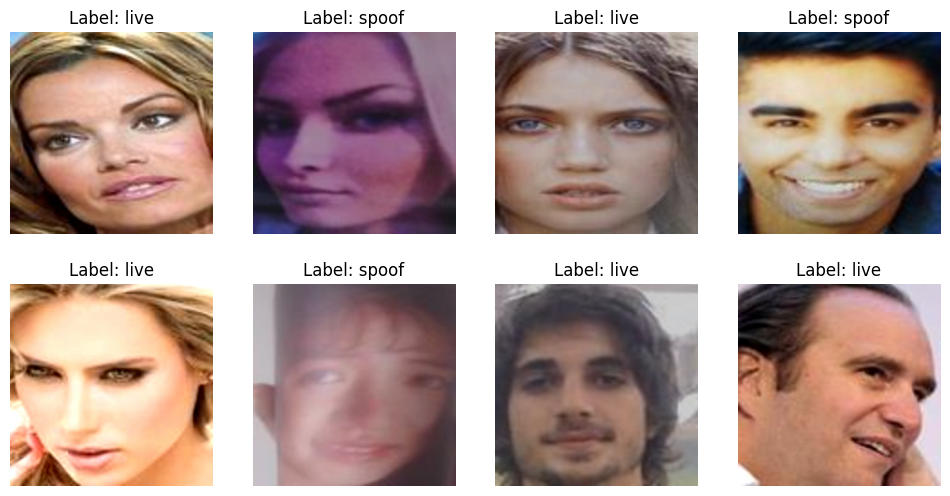

In [7]:
import matplotlib.pyplot as plt

def show_batch(dl):
    images, labels = next(iter(dl))
    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        # Un-normalize for display
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.title(f"Label: {full_train_dataset.classes[labels[i]]}")
        plt.axis('off')
    plt.show()

show_batch(train_loader)

## Training

In [8]:
import torch.nn as nn
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

class LivenessModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pre-trained weights for transfer learning
        self.backbone = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
        
        # Replace the 1000-class classifier with a single logit output
        in_features = self.backbone.classifier[3].in_features
        self.backbone.classifier[3] = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.backbone(x)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using M2 Pro GPU (MPS) 🚀")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

model = LivenessModel().to(device)

Using M2 Pro GPU (MPS) 🚀


In [9]:
def calculate_iso_metrics(outputs, labels, threshold=0.0):
    # outputs are logits; threshold 0.0 corresponds to a probability of 0.5
    preds = (outputs > threshold).float()
    
    # 0 = Live (Bona Fide), 1 = Spoof (Attack)
    # APCER: False Accept Rate (Spoofs accepted as Live)
    spoof_indices = (labels == 1)
    if spoof_indices.sum() > 0:
        apcer = (preds[spoof_indices] == 0).float().mean()
    else:
        apcer = torch.tensor(0.0)
        
    # BPCER: False Reject Rate (Lives rejected as Spoof)
    live_indices = (labels == 0)
    if live_indices.sum() > 0:
        bpcer = (preds[live_indices] == 1).float().mean()
    else:
        bpcer = torch.tensor(0.0)
        
    return apcer.item(), bpcer.item()

In [10]:
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn as nn
import numpy as np

history = {
    'train_loss': [], 'val_loss': [],
    'val_apcer': [], 'val_bpcer': []
}

# 1. Setup Optimizer with Weight Decay (L2 Regularization)
# Added weight_decay to help close the gap between Train and Val loss
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# 2. Add a Learning Rate Scheduler
# This will reduce the LR by half if Val Loss doesn't improve for 2 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

best_val_loss = float('inf')
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    # --- Training Phase ---
    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}")
        for images, labels in tepoch:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    # --- Evaluation Phase ---
    model.eval()
    val_loss_total = 0
    val_apcer_list, val_bpcer_list = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
            
            logits = model(images)
            v_loss = criterion(logits, labels)
            val_loss_total += v_loss.item()
            
            apcer, bpcer = calculate_iso_metrics(logits, labels)
            val_apcer_list.append(apcer)
            val_bpcer_list.append(bpcer)
    
    # --- Epoch Summary Calculations ---
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss_total / len(val_loader)
    avg_apcer = np.mean(val_apcer_list)
    avg_bpcer = np.mean(val_bpcer_list)
    
    # Update History
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_apcer'].append(avg_apcer)
    history['val_bpcer'].append(avg_bpcer)
    
    # 3. Step the Scheduler based on Validation Loss
    scheduler.step(avg_val_loss)
    
    # 4. Save Best Model (Checkpointing)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_anti_spoofing_model.pth')
        print(f"⭐ New Best Val Loss! Model saved.")

    print(f"✅ Epoch {epoch+1} Finished | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"APCER: {avg_apcer:.4f} | BPCER: {avg_bpcer:.4f}")

  0%|          | 0/638 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

⭐ New Best Val Loss! Model saved.
✅ Epoch 1 Finished | Train Loss: 0.2244 | Val Loss: 0.7475 | APCER: 0.4450 | BPCER: 0.0253


  0%|          | 0/638 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

✅ Epoch 2 Finished | Train Loss: 0.1199 | Val Loss: 0.9455 | APCER: 0.4995 | BPCER: 0.0135


  0%|          | 0/638 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

⭐ New Best Val Loss! Model saved.
✅ Epoch 3 Finished | Train Loss: 0.0901 | Val Loss: 0.4828 | APCER: 0.2578 | BPCER: 0.0461


  0%|          | 0/638 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

⭐ New Best Val Loss! Model saved.
✅ Epoch 4 Finished | Train Loss: 0.0752 | Val Loss: 0.3551 | APCER: 0.1927 | BPCER: 0.0647


  0%|          | 0/638 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

✅ Epoch 5 Finished | Train Loss: 0.0565 | Val Loss: 0.6816 | APCER: 0.3285 | BPCER: 0.0355


  0%|          | 0/638 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

✅ Epoch 6 Finished | Train Loss: 0.0491 | Val Loss: 0.5752 | APCER: 0.2840 | BPCER: 0.0504


  0%|          | 0/638 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

✅ Epoch 7 Finished | Train Loss: 0.0425 | Val Loss: 0.5112 | APCER: 0.2028 | BPCER: 0.0886


  0%|          | 0/638 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

✅ Epoch 8 Finished | Train Loss: 0.0252 | Val Loss: 1.2604 | APCER: 0.4305 | BPCER: 0.0133


  0%|          | 0/638 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

✅ Epoch 9 Finished | Train Loss: 0.0203 | Val Loss: 0.7253 | APCER: 0.2728 | BPCER: 0.0312


  0%|          | 0/638 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

✅ Epoch 10 Finished | Train Loss: 0.0194 | Val Loss: 0.7869 | APCER: 0.2496 | BPCER: 0.0362


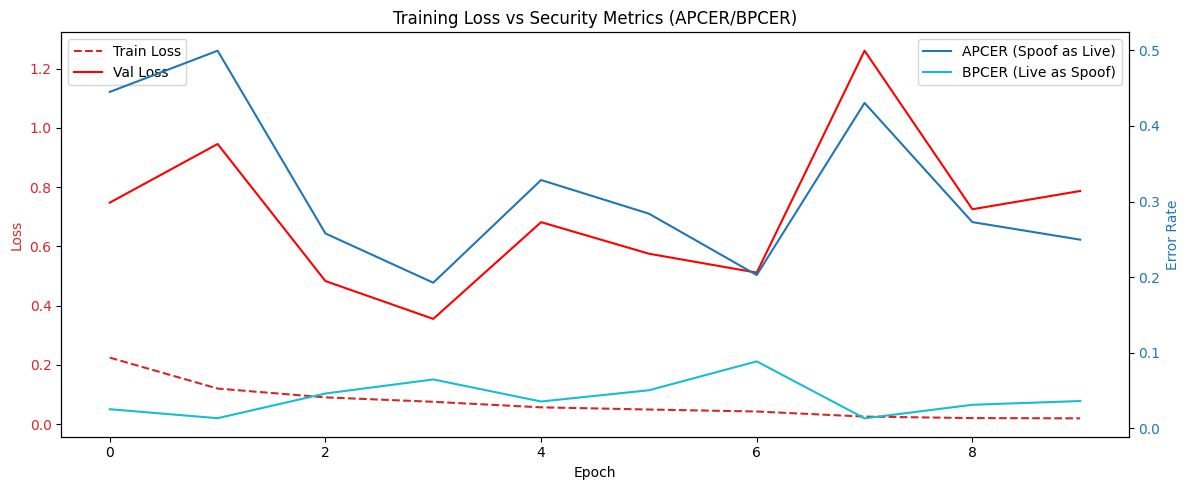

In [11]:
def plot_training_history(history):
    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Plot Loss
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(history['train_loss'], label='Train Loss', color='tab:red', linestyle='--')
    ax1.plot(history['val_loss'], label='Val Loss', color='red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Plot Security Metrics (APCER/BPCER) on a secondary Y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Error Rate', color='tab:blue')
    ax2.plot(history['val_apcer'], label='APCER (Spoof as Live)', color='tab:blue')
    ax2.plot(history['val_bpcer'], label='BPCER (Live as Spoof)', color='tab:cyan')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title('Training Loss vs Security Metrics (APCER/BPCER)')
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

plot_training_history(history)

## Testing

In [12]:
model.eval()
test_apcer, test_bpcer = [], []

print("🚀 Running Final Evaluation on Test Set...")
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        # Move to M2 GPU
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        
        logits = model(images)
        
        # calculate_iso_metrics should be the function we defined earlier
        apcer, bpcer = calculate_iso_metrics(logits, labels)
        test_apcer.append(apcer)
        test_bpcer.append(bpcer)

final_apcer = np.mean(test_apcer)
final_bpcer = np.mean(test_bpcer)

print(f"\n--- Final Test Results ---")
print(f"✅ APCER (Security): {final_apcer:.4f} (Goal: <0.01)")
print(f"✅ BPCER (Usability): {final_bpcer:.4f} (Goal: <0.05)")

🚀 Running Final Evaluation on Test Set...


Testing:   0%|          | 0/97 [00:00<?, ?it/s]


--- Final Test Results ---
✅ APCER (Security): 0.2436 (Goal: <0.01)
✅ BPCER (Usability): 0.0282 (Goal: <0.05)


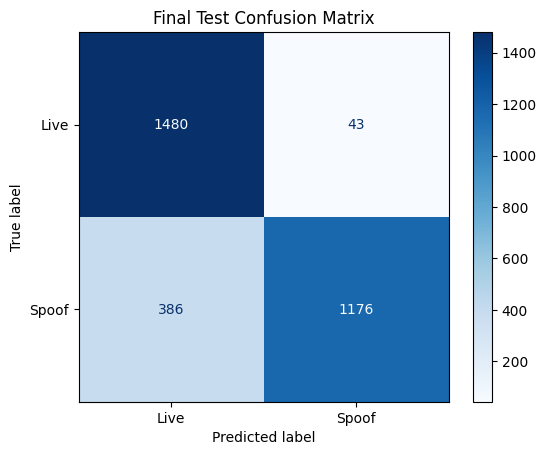

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_test_confusion_matrix(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Live', 'Spoof'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Final Test Confusion Matrix')
    plt.show()

plot_test_confusion_matrix(model, test_loader)

## Exporting

In [14]:
import torch.onnx
import os

model.eval()
model.to("cpu")
dummy_input = torch.randn(1, 3, 224, 224)

onnx_file_path = "../model/ekyc_liveness_mobilenetv3.onnx"
os.makedirs(os.path.dirname(onnx_file_path), exist_ok=True)

torch.onnx.export(
    model, 
    dummy_input, 
    onnx_file_path,
    export_params=True,
    opset_version=17,          # High enough to support MobileNetV3 ops natively
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'}, 
        'output': {0: 'batch_size'}
    },
    dynamo=False              # This is the key to stopping the errors you see
)

print(f"📦 Successfully exported without Dynamo errors to: {onnx_file_path}")

/var/folders/_l/9yt9fjns3yl8khq3hlylkj7w0000gn/T/ipykernel_3262/786508380.py:11: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


📦 Successfully exported without Dynamo errors to: ../model/ekyc_liveness_mobilenetv3.onnx


In [15]:
import onnxruntime as ort
import numpy as np

# Load the session
session = ort.InferenceSession(onnx_file_path)

# Run a test with a batch of 1
test_input = np.random.randn(1, 3, 224, 224).astype(np.float32)
outputs = session.run(None, {'input': test_input})

print(f"ONNX Output Shape: {outputs[0].shape}")
print(f"ONNX Raw Output (Logit): {outputs[0][0]}")

ONNX Output Shape: (1, 1)
ONNX Raw Output (Logit): [1.5264165]


## Upload to S3

In [16]:
import boto3
import os

def upload_model_to_s3(file_path, bucket, s3_key):
    s3 = boto3.client(
        "s3",
        region_name="ap-southeast-1"  # Singapore
)
    s3.upload_file(file_path, bucket, s3_key)
    print(f"✅ Model uploaded to s3://{bucket}/{s3_key}")

upload_model_to_s3(
    "../model/ekyc_liveness_mobilenetv3.onnx",
    "my-ekyc-assets",
    "models/ekyc/ekyc_liveness_mobilenetv3.onnx"
)


✅ Model uploaded to s3://my-ekyc-assets/models/ekyc/ekyc_liveness_mobilenetv3.onnx
